In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.interpolate import interp1d
import soundfile as sf

In [2]:
path = 'data/recorded_flicker_noise_mono.wav'
print(f"Loading audio file: {path}")
x, fs = sf.read(path)

print(f"Audio shape: {x.shape}")
print(f"Sampling frequency: {fs:.2f} Hz")  # Fixed: removed space
print(f"Duration: {len(x)/fs/3600:.2f} hours")
print(f"Audio dtype: {x. dtype}")
print(f"Audio range: [{x.min():.6f}, {x.max():.6f}]")  # Fixed: removed space here too

if len(x.shape) > 1:
    x = x[:, 0]
    print("Converted stereo to mono (using first channel)")

Loading audio file: data/recorded_flicker_noise_mono.wav
Audio shape: (345600000,)
Sampling frequency: 8000.00 Hz
Duration: 12.00 hours
Audio dtype: float64
Audio range: [-0.489197, 0.394379]


In [3]:
# Remove DC offset
x = x - np.mean(x)
print(f"DC offset removed.  New mean: {np.mean(x):.2e}")

# Compute PSD
# For 12-hour recording at 8000 Hz, use larger nperseg for better frequency resolution
nperseg = min(len(x), fs * 3600)  # 1-hour segments or full length if shorter
print(f"\nComputing PSD with nperseg={nperseg:,} samples...")

f, Pxx = welch(x, fs=fs, nperseg=nperseg)

print(f"PSD computed:")
print(f"  Frequency bins: {len(f)}")
print(f"  Frequency range: {f[1]:.6f} Hz to {f[-1]:.2f} Hz")
print(f"  Frequency resolution: {f[1]:.6f} Hz")


DC offset removed.  New mean: -1.12e-17

Computing PSD with nperseg=28,800,000 samples...
PSD computed:
  Frequency bins: 14400001
  Frequency range: 0.000278 Hz to 4000.00 Hz
  Frequency resolution: 0.000278 Hz



Noise floor level: 2.805e-10 V²/Hz (-95.5 dB/Hz)
1/f intersects measured PSD at: 7.621e-03 Hz

Plot saved: plots/flicker_noise_analysis_12h_1Hz.png


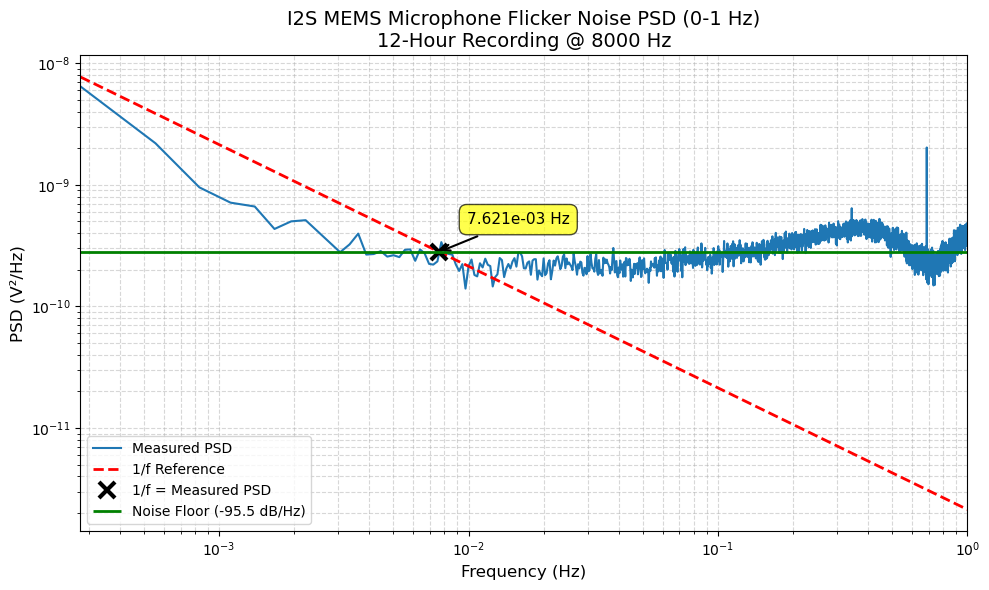


SUMMARY STATISTICS (0-1 Hz)
Recording duration: 12.00 hours
Sample rate: 8000 Hz
Total samples: 345,600,000
Frequency resolution: 0.000278 Hz
Lowest frequency analyzed: 0.000278 Hz
Highest frequency analyzed: 1.00 Hz
1/f noise dominates below: 7.621e-03 Hz
RMS voltage (AC): 0.000714 V


In [14]:
# Filter data to only include frequencies below 1 Hz
freq_limit = 1  # Hz
mask_100 = f <= freq_limit
f_filtered = f[mask_100]
Pxx_filtered = Pxx[mask_100]

# Plot measured PSD (below 1 Hz only)
plt.figure(figsize=(10, 6))
plt.loglog(f_filtered[1:], Pxx_filtered[1:], label='Measured PSD', linewidth=1.5)  # Skip DC component

# 1/f reference line (below 1 Hz)
f_ref = np. logspace(np.log10(f_filtered[1]), np. log10(f_filtered[-1]), 10000)  # log-spaced for better resolution

# Normalize to measured PSD at a reference frequency
freq_norm = 0.01  # 0. 01 Hz reference (adjust if needed)
idx_norm = np. argmin(np.abs(f_filtered - freq_norm))
p_ref = Pxx_filtered[idx_norm]
ref_line = p_ref * (freq_norm / f_ref)

plt.loglog(f_ref, ref_line, 'r--', label='1/f Reference', linewidth=2)

# Find where 1/f reference intersects with measured PSD
# Interpolate measured PSD to match f_ref frequencies
Pxx_interp = np.interp(f_ref, f_filtered, Pxx_filtered)

# Find intersection: where 1/f crosses measured PSD
# Look for where ref_line goes below measured PSD
diff = ref_line - Pxx_interp
sign_changes = np.where(np.diff(np.sign(diff)))[0]

if len(sign_changes) > 0:
    # Take the first intersection (lowest frequency)
    idx_cross = sign_changes[0]
    f_cross = f_ref[idx_cross]
    P_cross = ref_line[idx_cross]
    
    # Now set noise floor at the intersection point
    noise_floor_level = P_cross
    
    plt.plot(f_cross, P_cross, 'kx', markersize=12, markeredgewidth=3, label='1/f = Measured PSD')
    plt.annotate(f'{f_cross:.3e} Hz', 
                 xy=(f_cross, P_cross), 
                 xytext=(20, 20), 
                 textcoords='offset points',
                 arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
                 fontsize=11,
                 bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))
    
    # Plot noise floor
    plt.hlines(noise_floor_level, f_filtered[1], f_filtered[-1], colors='g', linestyles='-', 
               label=f'Noise Floor ({10*np.log10(noise_floor_level):.1f} dB/Hz)', linewidth=2)
    
    print(f"\nNoise floor level: {noise_floor_level:.3e} V²/Hz ({10*np.log10(noise_floor_level):.1f} dB/Hz)")
    print(f"1/f intersects measured PSD at: {f_cross:.3e} Hz")
else:
    f_cross = np.nan
    print("No intersection found between 1/f line and measured PSD")

# Plot formatting
plt.xlabel('Frequency (Hz)', fontsize=12)
plt.ylabel('PSD (V²/Hz)', fontsize=12)
plt.title(f'I2S MEMS Microphone Flicker Noise PSD (0-{freq_limit} Hz)\n12-Hour Recording @ {fs} Hz', fontsize=14)
plt.legend(fontsize=10, loc='best')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt. xlim(f_filtered[1], freq_limit)  # Set x-axis limit
plt.tight_layout()

# Save figure
plt.savefig(f'plots/flicker_noise_analysis_12h_{freq_limit}Hz.png', dpi=300, bbox_inches='tight')
print(f"\nPlot saved: plots/flicker_noise_analysis_12h_{freq_limit}Hz.png")
plt. show()

# Optional: Print summary statistics
print("\n" + "="*50)
print(f"SUMMARY STATISTICS (0-{freq_limit} Hz)")
print("="*50)
print(f"Recording duration: {len(x)/fs/3600:.2f} hours")
print(f"Sample rate: {fs} Hz")
print(f"Total samples: {len(x):,}")
print(f"Frequency resolution: {f[1]:.6f} Hz")
print(f"Lowest frequency analyzed: {f_filtered[1]:.6f} Hz")
print(f"Highest frequency analyzed: {f_filtered[-1]:.2f} Hz")
if not np. isnan(f_cross):
    print(f"1/f noise dominates below: {f_cross:.3e} Hz")
print(f"RMS voltage (AC): {np.sqrt(np. mean(x**2)):.6f} V")
print("="*50)